In [6]:
import math
import matplotlib.pyplot as plt
import matplotlib.lines as mpl_lines
import numpy as np
import cmasher as cmr

from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, mark_inset, InsetPosition, BboxConnector, TransformedBbox)
from matplotlib.transforms import (Bbox)

%matplotlib widget

# code modified to change negative values to positive ones
def lmap(f,x):
    return list(map(f,x))

# code modified to change negative values to positive ones
def lfilter(f,x):
    return list(filter(f,x))

def loadCSV(path, x_id=0, y_id=1):
    with open(path) as inp:
        lines = inp.read().split("\n")[1:-2]
        rows = lmap(lambda l: lmap(float, l.strip().split(",")), lines)

        return {"x": lmap(lambda r: r[x_id], rows), "y": lmap(lambda r: r[y_id], rows)}

def loadResultsCSV(path):
    def _f(x):
        if(x == "True"):
            return True
        elif (x=="False"):
            return False
        else:
            return float(x)
        
    with open(path) as inp:
        lines = inp.read().strip().split("\n")[1:]
        rows = lmap(
            lambda l: 
                lmap(
                _f, 
                l.strip().split(",")
            ), 
            lines
        )

        return ({
            "length": lines.__len__(),
            "d": lmap(lambda r: r[0], rows), 
            "o": lmap(lambda r: r[1], rows),
            "k": lmap(lambda r: r[2], rows),
            "ang": lmap(lambda r: r[3], rows),
            "t": lmap(lambda r: r[4], rows),
            "avg": lmap(lambda r: r[5], rows),
            "dev": lmap(lambda r: r[6], rows),
            "std": lmap(lambda r: r[7], rows),
            "switch": lmap(lambda r: r[8], rows),
            "der_avg": lmap(lambda r: r[9], rows),
            "linfit_m": lmap(lambda r: r[10], rows),
        }, lines.__len__())

In [7]:
# load the results data
(data, _len) = loadResultsCSV("./results.csv")

# Generate O and K axis values
O = []
o = 0.25
while o <= 100:
    O.append(o)
    o = o + 0.25
    o = round(o * 10000) / 10000

K = []
k = 0.95
while k < 1.6:
    K.append(k)
    k = k + 0.01
    k = round(k * 10000) / 10000

# Generate the output plot arrays
O = np.array(O)
K = np.array(K)
C1 = np.full(shape=(K.__len__(), O.__len__()), fill_value=0, dtype=float)
C2 = np.full(shape=(K.__len__(), O.__len__()), fill_value=0, dtype=float)
C3 = np.full(shape=(K.__len__(), O.__len__()), fill_value=0, dtype=float)

# constants
spinner_r = 3.59
plot_in_terms_of_spinner_r = [True, False, False]

# plot options
max_offset = 0.5
max_avg_dev = 0.1
possible_modes = [1 / 3, 1 / 2, 2 / 3, 4 / 3, 6 / 5, 3 / 2, 1, 2, 3, 4, 5, 6, 7]
mode_ticks = [
    "1/3",
    "1/2",
    "2/3",
    "4/3",
    "6/5",
    "3/2",
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
]
possible_modes_dev = 0.1

# cmap
(active_min, active_max) = (1 / 2, 4 / 3)
(_cmap_min, _cmap_max) = (0.15, 0.9)
_cmap = cmr.get_sub_cmap(
    "gist_ncar_r",
    _cmap_min
    + (active_min - min(possible_modes))
    / (max(possible_modes) - min(possible_modes))
    * (_cmap_max - _cmap_min),
    _cmap_min
    + (active_max - min(possible_modes))
    / (max(possible_modes) - min(possible_modes))
    * (_cmap_max - _cmap_min),
)

# go through all the data and set the appropriate plot values for each plot
for i in range(_len):
    if data["d"][i] == 8 and data["ang"][i] == 0 and data["t"][i] == 25:
        try:
            o_id = np.where(O == data["o"][i])[0][0]
            k_id = np.where(K == data["k"][i])[0][0]

            # --------------------------------- PLOT 1 ---------------------------------
            C1[k_id, o_id] = None
            if not data["switch"][i]:
                if abs(data["linfit_m"][i]) < 1e-3:
                    # stable mode
                    for r in possible_modes:
                        if (
                            -data["avg"][i] > r - possible_modes_dev
                            and -data["avg"][i] < r + possible_modes_dev
                        ):
                            C1[k_id, o_id] = r

            # --------------------------------- PLOT 2 ---------------------------------
            # -1 = default
            # 0 = stable mode
            # 3 = low interaction
            # 1 = equilibrium around 0
            # 2 = chaos
            C2[k_id, o_id] = -1
            if not data["switch"][i]:
                if abs(data["linfit_m"][i]) < 1e-3:
                    # stable mode
                    C2[k_id, o_id] = 0
                else:
                    # low interaction
                    C2[k_id, o_id] = 3
            else:
                if abs(data["linfit_m"][i]) < 5e-5:
                    # equilibrium around 0
                    C2[k_id, o_id] = 1
                else:
                    # chaos
                    C2[k_id, o_id] = 2

            # --------------------------------- PLOT 3 ---------------------------------

            C3[k_id, o_id] = max(min(np.log10(data["dev"][i]), 1), -5)

        except:
            pass

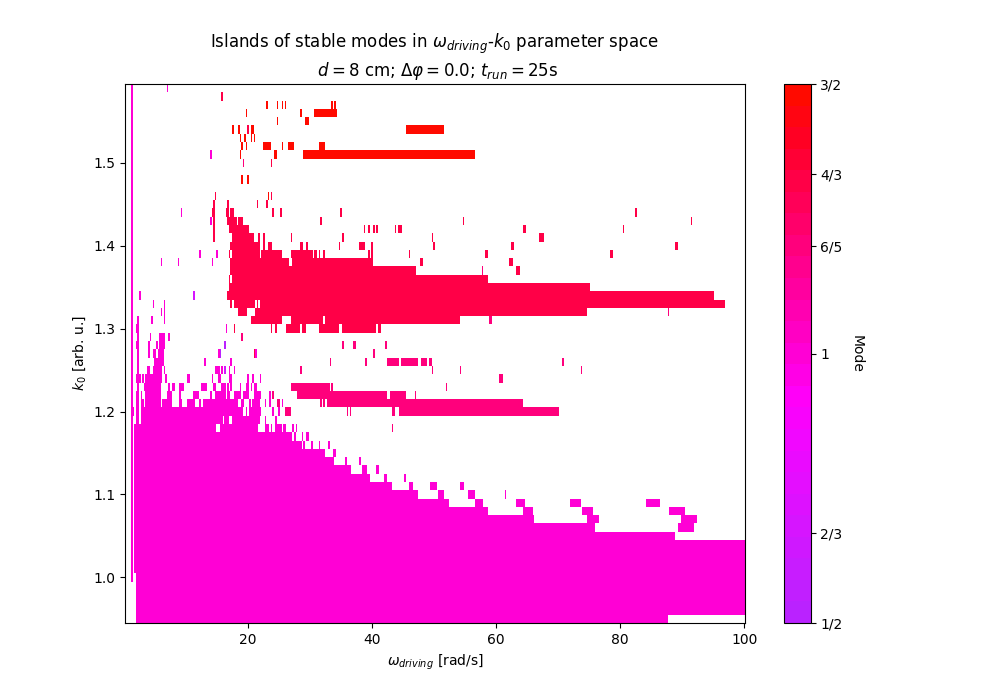

In [8]:
# PLOT 1 - total mode stability overview
plt.figure(figsize=(10, 7))
plt.title(
    "Islands of stable modes in $\omega_{driving}$-$k_0$ parameter space \n $d = 8$ cm; $\Delta \\varphi = 0.0$; $t_{run} = 25$s"
)
plt.ylabel("$k_0$ [arb. u.]")

plt.xlabel("$\omega_{driving}$ [rad/s]")
plt.pcolormesh(O, K, C1, cmap=_cmap)

cbar = plt.colorbar(ticks=possible_modes)
cbar.ax.set_yticklabels(mode_ticks)
cbar.set_label("Mode", rotation=270, labelpad=15)

plt.savefig("./imgs/omega_stable_modes.png", dpi=1200)

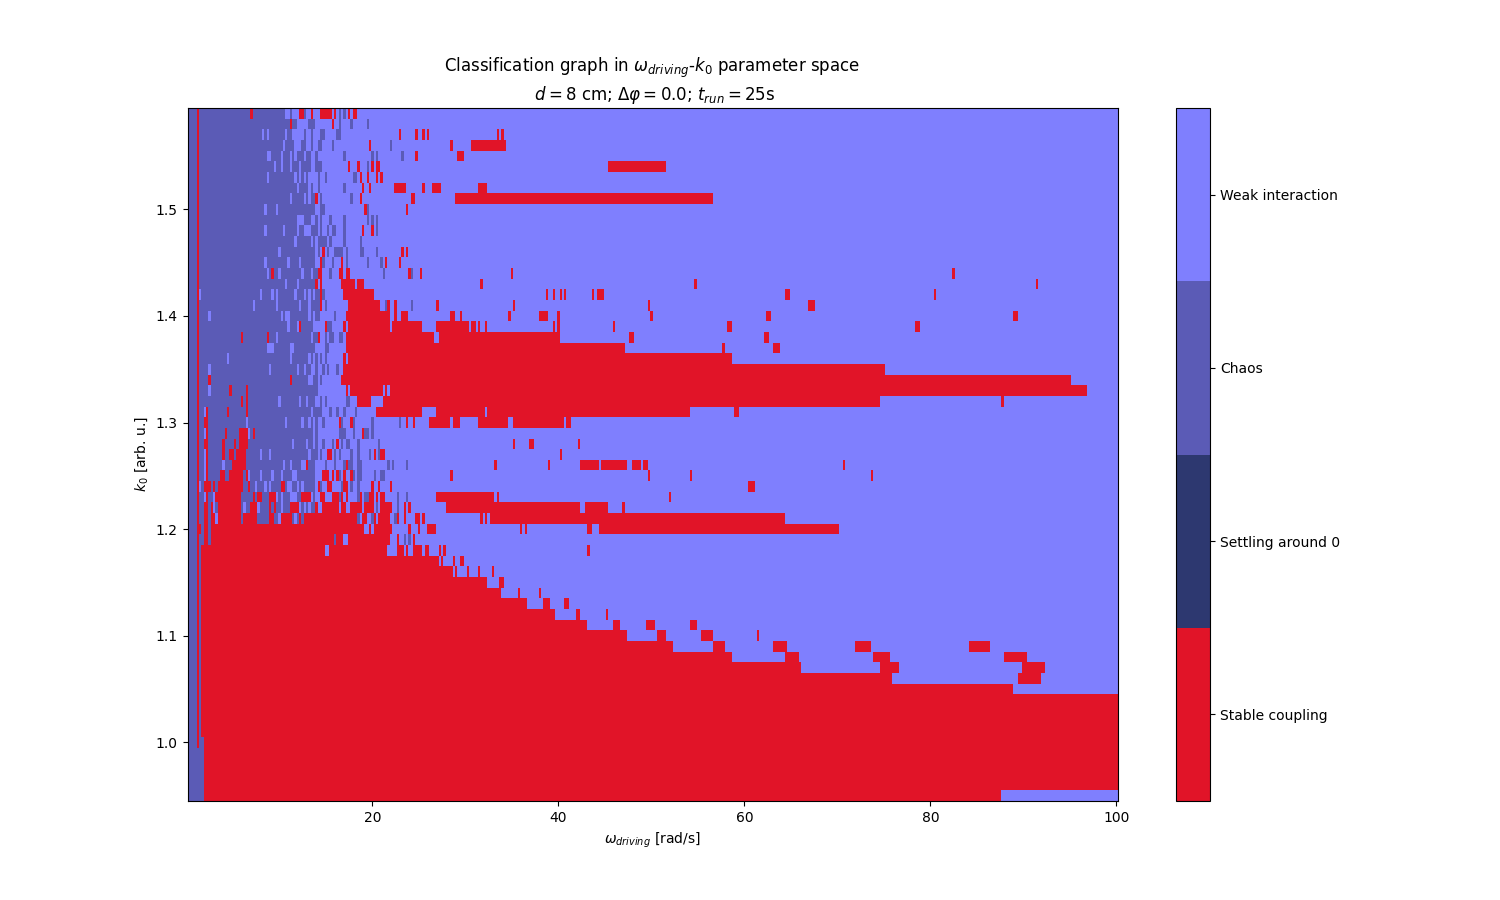

In [9]:
# PLOT 2 - behavior classification

# -1 = default
# 0 = stable mode
# 3 = low interaction
# 1 = equilibrium around 0
# 2 = chaos

fig, ax = plt.subplots(figsize=(15, 9))
plt.title(
    "Classification graph in $\omega_{driving}$-$k_0$ parameter space \n $d = 8$ cm; $\Delta \\varphi = 0.0$; $t_{run} = 25$s"
)
plt.ylabel("$k_0$ [arb. u.]")
# plt.ylabel("$\omega_{driven} / \omega_{driving}$ [arb. u.]")

plt.xlabel("$\omega_{driving}$ [rad/s]")
plt.pcolormesh(O, K, C2, cmap=cmr.get_sub_cmap("gist_stern", 0.08, 0.5, N=4))

cbar = plt.colorbar()
cbar.set_ticks([3 / 4 - 3 / 8, 2 * 3 / 4 - 3 / 8, 3 * 3 / 4 - 3 / 8, 3 - 3 / 8])
cbar.ax.set_yticklabels(
    ["Stable coupling", "Settling around 0", "Chaos", "Weak interaction"]
)


def make_inset(o, k, w=0.25, h=0.2, pad=(0.1, 0.125)):
    (xmin, xmax) = ax.get_xlim()
    (ymin, ymax) = ax.get_ylim()

    dat = loadCSV(f"./runs/d={8:.4f}_o={o:.2f}_k={k:.3f}_ang={0.:.4f}_t={25:.3f}.csv")

    inset_ax = inset_axes(
        ax,
        width=str(w * 100) + "%",
        height=str(h * 100) + "%",
        bbox_to_anchor=(
            (o - xmin) / (xmax - xmin) + pad[0],
            (k - ymin) / (ymax - ymin) + pad[1],
            1,
            1,
        ),
        loc=3,
        bbox_transform=ax.transAxes,
    )

    inset_ax.set_xlabel("$t$ [s]", labelpad=5)
    inset_ax.set_xticks(np.round(np.linspace(0, dat["x"][-1], 6)))
    inset_ax.xaxis.tick_top()

    inset_ax.yaxis.tick_right()

    inset_ax.plot(dat["x"], lmap(lambda y: -y, dat["y"]))

    # ip = InsetPosition(ax,[(d-xmin)/(xmax-xmin) + pad[0], (k-ymin)/(ymax-ymin) + pad[1],w,h])
    # inset_ax.set_axes_locator(ip)
    # ax.indicate_inset_zoom(inset_ax, )

    bb = Bbox.from_bounds(0, 0, 0.1, 0.1).anchored(
        ((o - xmin) / (xmax - xmin), (k - ymin) / (ymax - ymin)),
        ax.bbox,
    )
    p1 = BboxConnector(inset_ax.bbox, bb, 2)
    p2 = BboxConnector(inset_ax.bbox, bb, 4)
    ax.add_patch(p1)
    ax.add_patch(p2)

# make_inset(1.25, 1.4, pad = (0.01, 0.01))
# make_inset(1.25, 0.95, pad = (0.01, 0.01))
# make_inset(40, 1.22, pad = (-0.31, -0.25))
# make_inset(50, 1.51, pad = (-0.31, -0.25))
# make_inset(90, 1.33, pad = (-0.31, -0.25))

plt.savefig("./imgs/omega_classification.png")

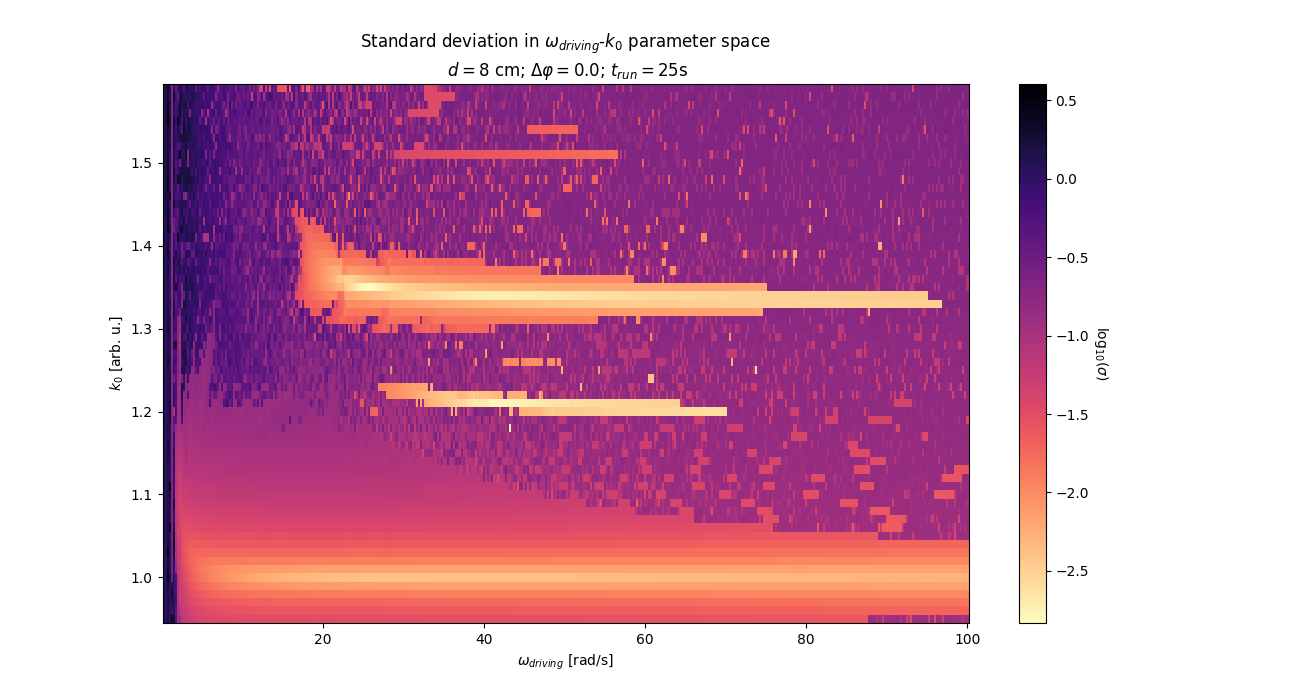

In [10]:
# PLOT 3 - deviation plot
plt.figure(figsize=(13, 7))
plt.title(
    "Standard deviation in $\omega_{driving}$-$k_0$ parameter space \n $d = 8$ cm; $\Delta \\varphi = 0.0$; $t_{run} = 25$s"
)
plt.ylabel("$k_0$ [arb. u.]")

plt.xlabel("$\omega_{driving}$ [rad/s]")
plt.pcolormesh(O, K, C3, cmap="magma_r")

cbar = plt.colorbar()
cbar.set_label("$\log_{10}(\sigma)$", rotation=270, labelpad=15)
# cbar.set_ticks(np.linspace(-5, 1, 7))
# cbar.ax.set_yticklabels(["< -5", "-4", "-3", "-2", "-1", "0", "> 1"])

plt.savefig("./imgs/omega_deviations.png", dpi=1200)
pass